# Optimizations

This notebook includes several improvements and optimizations compared to the previous sections. For instance,
lists are avoided entirely, and the computation of the Maximization step uses efficient bits of code from sklearn.

(1000, 2)

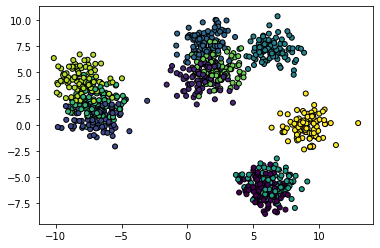

In [1]:
from kuberspatiotemporal.tools import make_gmm
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs

%matplotlib inline 
n_clusters=10
# X,y = make_gmm(1000, n_clusters=n_clusters)
X,y = make_blobs(1000, 2, n_clusters)

display(X.shape)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

In [6]:
from typing import List, Optional, Callable, Tuple
import logging
from scipy.stats import multivariate_normal as mvn
from sklearn.datasets import make_spd_matrix
import numpy as np
from numpy.random import random_sample
import attr
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
import time
from scipy import linalg as scipy_linalg

from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
    _compute_log_det_cholesky
)
from kuberspatiotemporal.tools import (
    check_spd, 
    check_singular,
    make_ellipses,
    repr_list_ndarray
)

%matplotlib inline

# Always useful: https://stackoverflow.com/a/44401529
logging.basicConfig(format='[%(funcName)s:%(lineno)d] %(message)s')
logger = logging.getLogger(__name__)

logger.setLevel(logging.DEBUG)
    
##################
# tools.py
##################

def repr_ndarray(x: np.ndarray) -> str:
    return f"Array {x.shape}" if x is not None else "None"


def cholesky_precisions(x: np.ndarray) -> Tuple[np.ndarray,np.ndarray]:
    n_components, n_features, _ = x.shape
    
    precisions_chol = np.empty((n_components, n_features, n_features))
    for k, covariance in enumerate(x):
        try:
            cov_chol = scipy_linalg.cholesky(covariance, lower=True)
            # cov_chol2 = np.linalg.cholesky(covariance)
            # assert np.allclose(cov_chol,cov_chol2)
        except scipy_linalg.LinAlgError:
            raise ValueError("Could not invert")
        precisions_chol[k] = scipy_linalg.solve_triangular(cov_chol,
                                                     np.eye(n_features),
                                                     lower=True).T # cannot be vectorized :(
        
        
    
    n_components, _, _ = precisions_chol.shape
    log_det_chol = (np.sum(np.log(
        precisions_chol.reshape(
            n_components, -1)[:, ::n_features + 1]), 1))
    return precisions_chol, log_det_chol

def make_ellipses(gmm: "GaussianMixtureModel", ax, min_weight=0.0):
    """Shamelessly stolen from
    https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html"""

    # pylint: disable=invalid-name

    colors = [
        "navy",
        "turquoise",
        "darkorange",
        "firebrick",
        "yellowgreen",
        "mediumorchid",
        "slateblue",
        "darkcyan",
        "gold",
        "mediumpurple",
        "navajowhite",
    ] * 30

    for n, color in enumerate(colors):

        if n == gmm.n_components:
            break

        if gmm.weights[n] < min_weight:
            continue
        covariances = gmm.covs[n]

        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means[n], v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

##################
# dpm.py
##################

@attr.s
class GaussianMixtureModel:

    # public attributes
    n_components: int = attr.ib()
    n_dim: int = attr.ib(default=2)
    alpha: float = attr.ib(default=0.75)
    start_maximimization: int = attr.ib(default=5)
    nonparametric: bool = attr.ib(default=True)
    scaling_parameter: float = attr.ib(default=2.0)
    min_eigval: float = attr.ib(default=1e-2)
    # Internal state variables
    counter: int = attr.ib(default=0)  # This is intended for resuming / incremental
    priors: Optional[np.ndarray] = attr.ib(default=None, repr=repr_ndarray)
    weights: Optional[np.ndarray] = attr.ib(default=None, repr=repr_ndarray)
    means: Optional[np.ndarray] = attr.ib(default=None, repr=repr_ndarray)
    covs: Optional[np.ndarray] = attr.ib(default=None, repr=repr_ndarray)
    sufficient_statistics: List[np.ndarray] = attr.ib(factory=list, repr=lambda x: repr_list_ndarray)
    cached_regularization: Optional[np.ndarray] = attr.ib(default=None, repr=False)
    limits: Tuple[np.ndarray,np.ndarray] = attr.ib(default=None) # should have a validator
    
    # To compare new implementation with legacy code + time measurements
    compare_expects: bool = attr.ib(default=False)
    
    alternator: int = attr.ib(default=0)
   
    def __attrs_post_init__(self):
        if self.limits is None:
            self.limits = (np.zeros(self.n_dim),np.ones(self.n_dim))
            

        if self.means is None:
            # (b - a) * random_sample() + a
            self.means = (
                (self.limits[1]-self.limits[0]) 
                * np.random.random((self.n_components, self.n_dim,)) 
                + self.limits[0]
            )
            
        if self.covs is None:
             self.covs =  ( 
                 np.tile(np.identity(self.n_dim),(self.n_components,1,1)) 
                 * np.random.rand(self.n_components)[:,np.newaxis,np.newaxis]  #(1/self.n_components)
                 *10
             )
                                                                                
            # Dangerous: too much overlap leads to too small responsibilites
            
        if not self.sufficient_statistics:
            self.sufficient_statistics = [
                np.zeros((self.n_components,)),
                np.zeros((self.n_components, self.n_dim)),
                np.zeros((self.n_components, self.n_dim, self.n_dim))
            ]
            
            
        if not self.sufficient_statistics:
            self.sufficient_statistics = [
                np.zeros((self.n_components,)),
                np.zeros((self.n_components, self.n_dim)),
                np.zeros((self.n_components, self.n_dim, self.n_dim))
            ]    
            
        if self.priors is None:
            self.priors = np.random.beta(1,self.scaling_parameter,(self.n_components,))
            self.priors[-1] = 1.0 # truncate
        
        if self.weights is None:
            if not self.nonparametric:
                self.weights = np.ones((self.n_components,)) * 1.0 / self.n_components
                print('Noope')
            else:
                self.weights = self.stick_breaking()

        
        if self.cached_regularization is None:
            self.cached_regularization = np.identity(self.n_dim)*1e-6
            
        logger.info('GMM initiailized')

    def stick_breaking(self)->np.ndarray:
        weights = np.empty(self.priors.shape)
        self.priors[-1] = 1.0 # truncate
        
        weights[0] = self.priors[0]
        weights[1:] = self.priors[1:] * np.cumprod(1 - self.priors)[:-1]
        
        return weights
        
        
    def randomize(fancy_index: np.ndarray):
        # unsure what to do with the weights but this might do
        self.weights[fancy_index] = 1 / self.n_components 
        self.weights /= np.sum(self.weights)
        self.means[fancy_index] = (
            (self.limits[1]-self.limits[0]) 
            * np.random.random((self.n_components, self.n_dim,)) 
            + self.limits[0])[fancy_index]
        self.covs[fancy_index] = np.identity(self.n_dim)


    def expect_bak(self, data: np.ndarray) -> List[List[float]]:
        start = time.time()
        
        responsibilities = []
        for t in range(data.shape[0]):
            try:
                
                denominator = np.sum([self.weights[i] * mvn.pdf(data[t],
                                                                self.means[i],
                                                                self.covs[i])
                                      for i in range(self.n_components)])

                row = [self.weights[i] / denominator
                              * mvn.pdf(data[t],
                                        self.means[i],
                                        self.covs[i])
                              for i in range(self.n_components)]
            except np.linalg.LinAlgError as err:
                logger.exception("Failed to compute the responsibilities, %s,\n%s,\n%s",
                                 err, [np.linalg.cond(x) for x in self.covs],
                                 [np.linalg.cond(x)>1e11 for x in self.covs])

            responsibilities.append(row)
        logger.info('Time spent: %s',time.time() - start)
        
        return responsibilities
    
    def expect(self, data: np.ndarray) -> List[List[float]]:
    

        start = time.time()

        n_samples = data.shape[0]
        
        # precisions = _compute_precision_cholesky(self.covs,'full') 
        # log_det = _compute_log_det_cholesky(precisions,'full', self.n_dim)
        precisions, log_det = cholesky_precisions(self.covs)
        
        # n - n_samples, d/e - n_dim, c - n_components
        log_prob = np.sum(np.square(
            np.einsum('nd,cde->nce', data, precisions) - 
            np.einsum('cd,cde->ce', self.means, precisions)[np.newaxis,:,:]), 
            axis=2)
       
        
        if self.compare_expects:
            log_prob_1 = np.empty((n_samples, self.n_components))
            
            for k, (mu, p) in enumerate(zip(self.means, precisions)):
                y = np.dot(data, p) - np.dot(mu, p)
                log_prob_1[:, k] = np.sum(np.square(y), axis=1)

    #         print(log_prob,log_prob_1, log_prob.shape,log_prob_1.shape)
            assert np.allclose(log_prob,log_prob_1)
        
        # weights can / should be zero (caught degenerates)
        with np.errstate(divide='ignore',invalid='ignore'): 

            weighted_prob = np.exp(
                -.5 * (self.n_dim * np.log(2 * np.pi) + log_prob) 
                + log_det + np.log(self.weights)[np.newaxis,:]
            )
        
#         log_responsibilities = weighted_log_prob - logsumexp(weighted_log_prob, axis=1)[:, np.newaxis]
        
        
#         logger.info(weighted_prob)
        with np.errstate(divide='ignore',invalid='ignore'): 

            responsibilities = weighted_prob / np.sum(weighted_prob, axis=1)[:,np.newaxis]
            
            responsibilities[np.isnan(responsibilities)] = 0

        
        if self.compare_expects:
            logger.info('Time spent: %s',time.time() - start)

        return responsibilities

    def predict(self, data: np.ndarray) -> np.ndarray:
        responsibilities = np.asarray(self.expect(data))
        return np.argmax(responsibilities,axis=1), responsibilities

        
        
    def maximize(self):

        
        if not self.nonparametric:
            self.weights = self.sufficient_statistics[0] / np.sum(self.sufficient_statistics[0])
        else:
#             logger.debug('before: %s', np.sort(self.weights))
            with np.errstate(divide='ignore',invalid='ignore'): 

                self.priors = self.sufficient_statistics[0] / ( 
                    self.scaling_parameter - 1 + np.flip(np.cumsum(np.flip(self.sufficient_statistics[0]))) 
                )
                self.priors[np.isnan(self.priors)] = 0.0
#                 assert np.all(self.priors>=0), f"priors {self.priors}"


            self.weights = self.stick_breaking()



                
            
        ########################################

        # suppress div by zero warinings (occur naturally for disabled components)


        
        with np.errstate(divide='ignore',invalid='ignore'): 

            self.means = self.sufficient_statistics[1] / self.sufficient_statistics[0][:, np.newaxis]

            self.covs = (
                self.sufficient_statistics[2] / self.sufficient_statistics[0][:, np.newaxis, np.newaxis]
                - np.einsum('ki,kj->kij', self.means, self.means)
            )  + self.cached_regularization[np.newaxis,:,:]


        
       
        # legacy checks
#         for i, cov in enumerate(self.covs):
            
# #             if self.sufficient_statistics[0][i] < self.n_dim +1:
# #                 self.weights[i] = 0.0
# #                 self.means[i] = np.ones(self.n_dim) * 0.0
# #                 self.covs[i] = np.identity(self.n_dim) * 0.01
#             if  np.any(np.isnan(cov)): #np.allclose(cov,0.0,atol=1e-4)  
#                 logger.error("NaN: %s, weight: %.6f, s0: %.6f, %.6f,%d,%s", 
#                              cov, self.weights[i],self.sufficient_statistics[0][i],
#                              3/self.counter/self.n_components,i,self.priors)
                
#             elif not check_spd(cov) or check_singular(cov, 1e5):
#                 logger.error('You should not be here! Reset component %s, weight: %.6f, number: %d',  
#                              cov, self.weights[i],i)


    def find_degenerated(self, method='eigen', remove=True):
        '''Remove irrelevant components'''
        
        if method=='eigen':
            # See https://www.visiondummy.com/2014/04/geometric-interpretation-covariance-matrix/ 
            # for what the eigenvalues mean geometrically
            self.covs[np.any(np.isnan(self.covs),axis=1)] = 0
            irrelevant = np.min(np.linalg.eigvals(self.covs),axis=1) < self.min_eigval
            
        elif method=='count':
            # In batch, self.sufficient_statistics is almost equal to self.counter
            # So we can estimate the number of points for each component and remove
            # those with less than enogh points (n+1, e.g., 3 points required in 2D 
            # as 2D only spans a line)
            # In incremental, the original assumption does not hold
            irrelevant = self.weights < (self.n_dim+1) / np.sum(self.sufficient_statistics[0]) 

        if remove:
            self.priors[irrelevant] = 0.0
            self.means[irrelevant] = 0
            self.covs[irrelevant] = np.identity(self.n_dim) * 1e-2

        if self.nonparametric:
            self.weights=self.stick_breaking()
        else:
            self.weights[irrelevant] = 0.0
            self.weights /= np.sum(self.weights)

        return np.sum(irrelevant)
        
    
    
    def batch(self, data: np.ndarray):

        n_samples = data.shape[0]
        self.counter = n_samples
        
        responsibilities = np.asarray(self.expect(data))
        if self.compare_expects:
            responsibilities2 = np.asarray(self.expect_bak(data))

            assert responsibilities.shape == responsibilities2.shape, 'shape mismatch'
            assert np.allclose(responsibilities, responsibilities2) ,\
                f"\n{responsibilities}\n.  !=\n{responsibilities2}"
        
        self.sufficient_statistics[0] = np.sum(
            responsibilities,  # (n_samples, n_components)
            axis=0
        )

        self.sufficient_statistics[1] = np.sum(
            responsibilities[:, :, np.newaxis] * data[:, np.newaxis, :],  # (n_samples, n_components, n_dim)
            axis=0
        )

        self.sufficient_statistics[2] = np.sum(
            responsibilities[:, :, np.newaxis, np.newaxis] *
            np.einsum('Ti,Tj->Tij', data, data)[:, np.newaxis, :, :],  # (n_samples, n_components, n_dim, n_dim)
            axis=0
        )
        self.maximize()
        self.find_degenerated()
        


    def incremental(self, data: np.ndarray):

        if self.counter == 0:
            self.sufficient_statistics[0] = (
                self.weights * 10
            )

            self.sufficient_statistics[1] = (
                self.sufficient_statistics[0][:,np.newaxis] * self.means
            )

            self.sufficient_statistics[2] = (
                self.sufficient_statistics[0][:,np.newaxis,np.newaxis] * 
                ( self.covs +
                np.einsum('ki,kj->kij', means, means) )
            ) 
            self.counter = 10
            
        logger.debug("%s, %f,%f,%f",self.sufficient_statistics[0]/np.sum(self.sufficient_statistics[0]),
                     np.sum(self.sufficient_statistics[0]),
                     (self.counter)**(-self.alpha),((self.counter)**(-self.alpha))**100)

        degs=0
        for sample in data:
            
#             logger.debug(self.counter)

            self.counter += 1

            responsibilities = np.asarray(self.expect(sample.reshape(1, -1))).reshape(-1)

            rate = (self.counter)**(-self.alpha)

            # First reduce the influence of the older samples
            for i in self.sufficient_statistics:
                i *= (1-rate)

            # Then introduce the new sample
            self.sufficient_statistics[0] += (
                rate * responsibilities
            )

            self.sufficient_statistics[1] += (
                rate * responsibilities[:, np.newaxis] * sample[np.newaxis, :]
            )

            self.sufficient_statistics[2] += (
                rate * responsibilities[:, np.newaxis, np.newaxis] *
                np.einsum('i,j->ij', sample, sample)[np.newaxis, :, :]
            )

#             if self.counter > self.start_maximimization:
            self.maximize()
    
            d = self.find_degenerated()
            if d!=degs:
                logger.debug("Detected %d degenerated", degs)
                degs=d
        logger.debug("Finished. Detected %d degenerated", degs)
        
    

    def fit(self, data: np.ndarray, n_iterations=100, online=False):

        if len(data.shape) != 2:
            raise ValueError(f"Wrong input dimensions (at least 2D)")

        if data.shape[1] != self.n_dim:
            raise ValueError(f"Wrong input dimensions {data.shape[1]} != {self.n_dim} ")

        if data.shape[0] == 0:
            logger.info("Empty data set")
            return
        logger.info("Learning %d samples (%s)", data.shape[0],
                     "Online" if online else "Batch")

        for i in range(n_iterations):
            if i % 10 == 0:
                logger.info('Step %d/%d', i, n_iterations)
            if online:
                self.incremental(data)
            else:
                self.batch(data)

    def get_logger(self):
        return logger
            
            

[__attrs_post_init__:186] GMM initiailized
[fit:490] Learning 1000 samples (Batch)
[fit:494] Step 0/1
[fit:490] Learning 1000 samples (Batch)
[fit:494] Step 0/1
[fit:490] Learning 1000 samples (Batch)
[fit:494] Step 0/1
[fit:490] Learning 1000 samples (Batch)
[fit:494] Step 0/1
[fit:490] Learning 1000 samples (Batch)
[fit:494] Step 0/1
[fit:490] Learning 1000 samples (Batch)
[fit:494] Step 0/1
[fit:490] Learning 1000 samples (Batch)
[fit:494] Step 0/50
[fit:494] Step 10/50
[fit:494] Step 20/50
[fit:494] Step 30/50
[fit:494] Step 40/50
[fit:490] Learning 1000 samples (Batch)
[fit:494] Step 0/50


sorted priors [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.032 0.035 0.038 0.039 0.054 0.055 0.125
 0.145 0.146 0.175 0.185 0.194 0.197 0.206 0.224 0.235 0.243 0.257 0.263
 0.274 0.294 0.329 1.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0

[fit:494] Step 10/50
[fit:494] Step 20/50
[fit:494] Step 30/50
[fit:494] Step 40/50
[fit:490] Learning 1000 samples (Batch)
[fit:494] Step 0/50


sorted priors [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.031 0.039 0.046
 0.066 0.134 0.153 0.182 0.194 0.205 0.208 0.21  0.219 0.236 0.259 0.26
 0.304 0.329 0.345 1.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.

[fit:494] Step 10/50
[fit:494] Step 20/50
[fit:494] Step 30/50
[fit:494] Step 40/50


sorted priors [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.032 0.035 0.045
 0.088 0.09  0.124 0.138 0.167 0.173 0.175 0.194 0.201 0.207 0.219 0.236
 0.294 0.295 0.347 1.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0

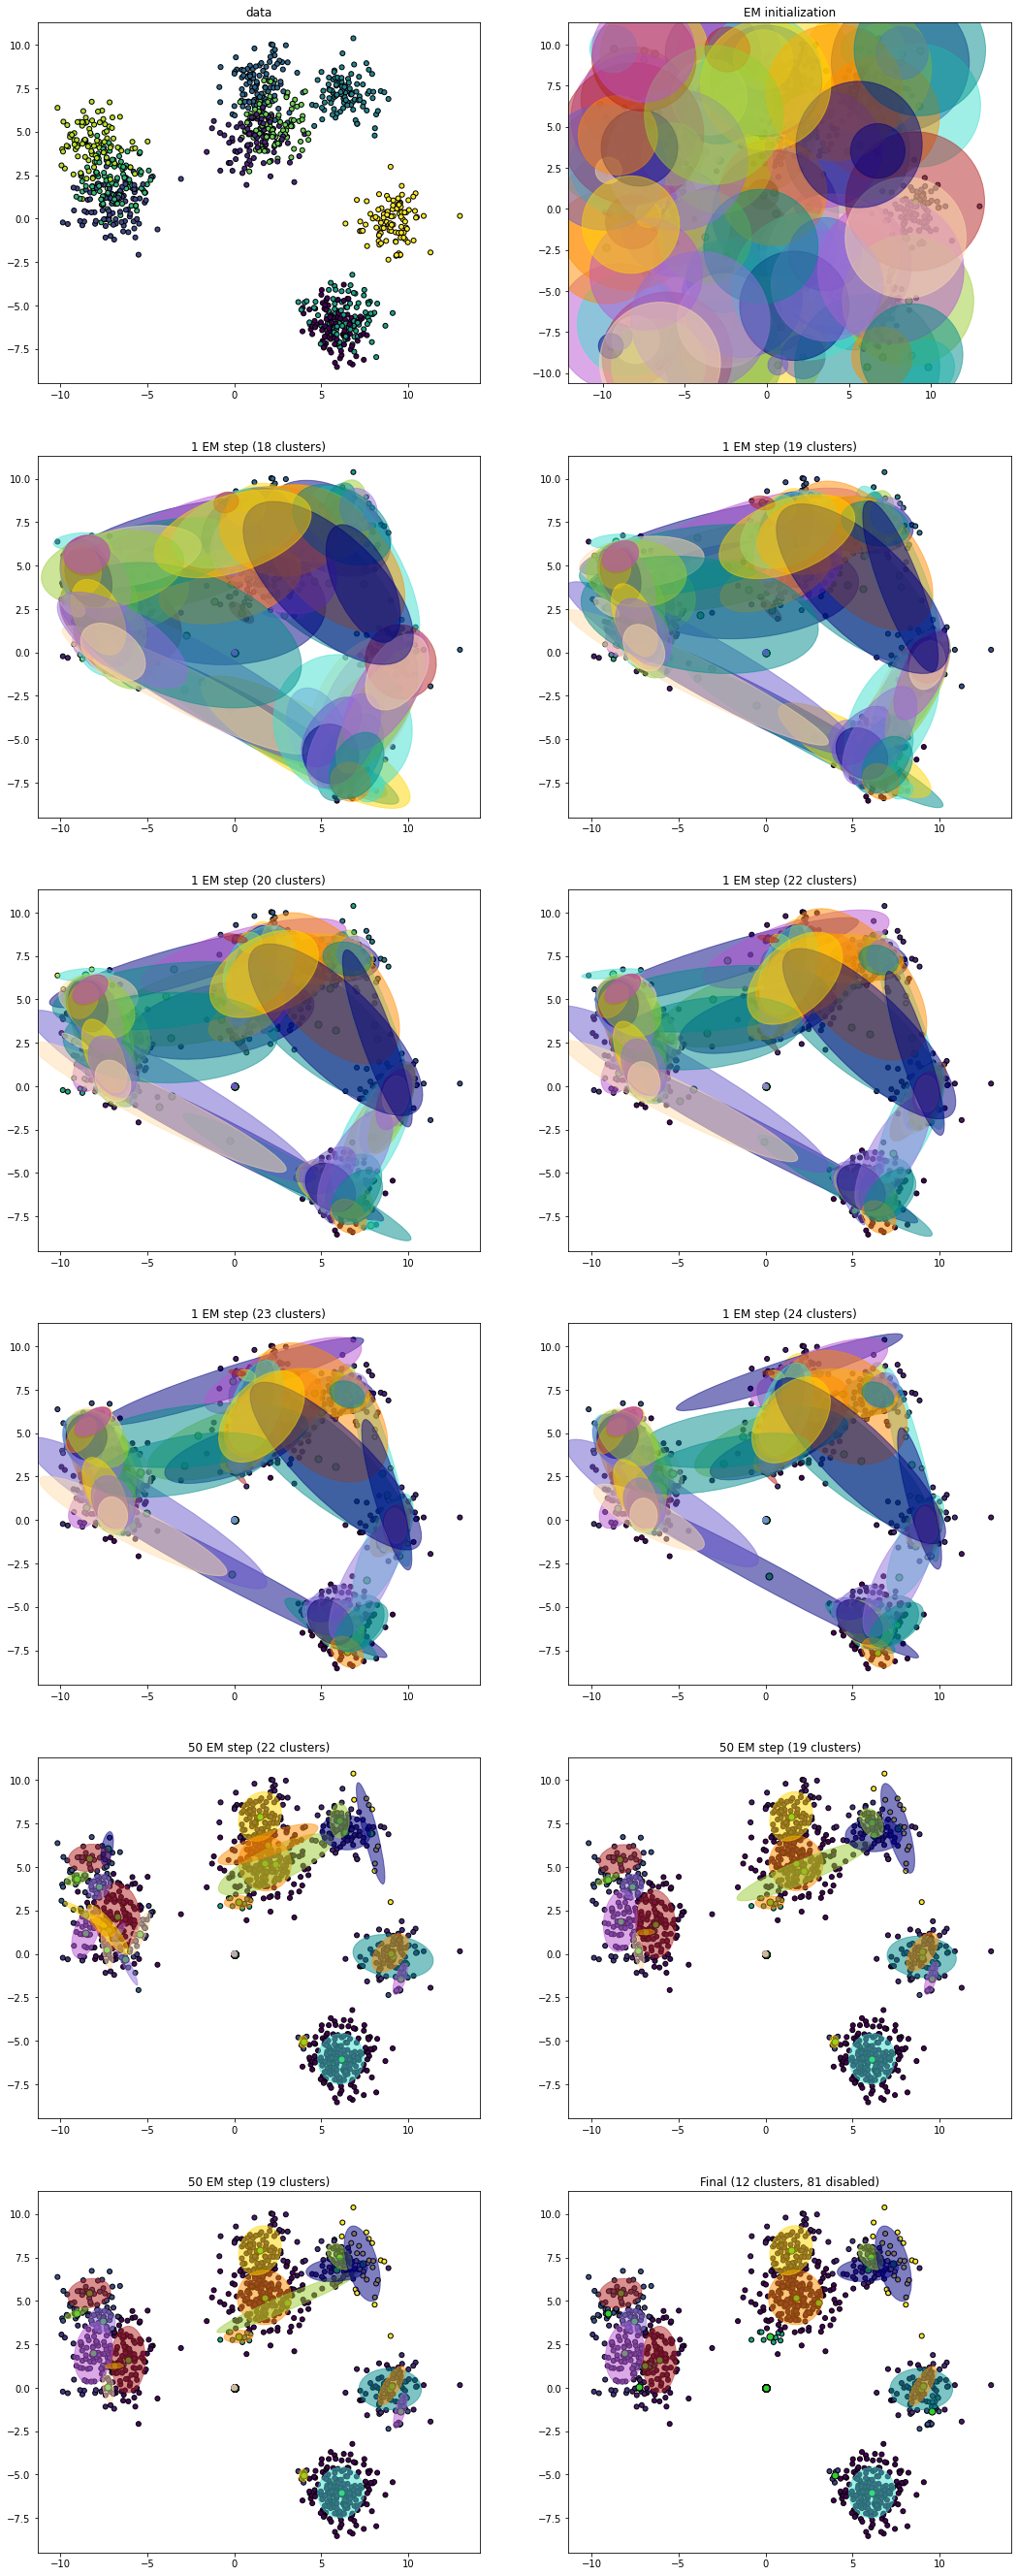

In [8]:
#############################
# batch, indiv iterations

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), 
    (ax7, ax8), (ax9, ax10), (ax11, ax12) ) = plt.subplots(6,2, figsize=(18, 48))

np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

np.seterr(divide='print')

gmm = GaussianMixtureModel(n_components=100, nonparametric=True, 
                           scaling_parameter=4,compare_expects=False, limits=np.array([[-10,-10],[10,10]]),
                           min_eigval=1e-2)

ax1.scatter(X[:, 0], X[:, 1], marker='o', c=y[:],
            s=25, edgecolor='k')
ax1.set_title('data')

# step 0 - initialization
make_ellipses(gmm, ax2)
p,r = gmm.predict(X)
# print(p,r)
means = np.asarray(gmm.means)
ax2.scatter(X[:, 0], X[:, 1], marker='o', c=gmm.predict(X)[0],
            s=25, edgecolor='k')

ax2.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
            s=50, edgecolor='k')
ax2.set_title('EM initialization')
# print("sorted weights", np.sorted(gmm.weights))

# step 1 - one EM

for axi in [ax3,ax4,ax5,ax6,ax7,ax8]:
    gmm.fit(X,n_iterations=1)
#     print("sorted weights", np.asarray(gmm.weights))
#     print("Sufficient statistics 0", gmm.sufficient_statistics[0])
    make_ellipses(gmm, axi)
    
    means = np.asarray(gmm.means)
    axi.scatter(X[:, 0], X[:, 1], marker='o', c=gmm.predict(X)[0],
                s=25, edgecolor='k')

    axi.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
                s=50, edgecolor='k')
    axi.set_title(f'1 EM step ({np.sum(gmm.weights > 1e-3)} clusters)')
    
    

for [axi,sp] in zip([ax9,ax10,ax11],[1.5, 2.0, 5.0]):
    gmm.fit(X,n_iterations=50)
#     print("sorted weights", np.sort(gmm.weights))
    print("sorted priors", np.sort(gmm.priors))
#     print("Sufficient statistics 0", gmm.sufficient_statistics[0])
    
    print(np.sort(gmm.weights))
    make_ellipses(gmm, axi)
    
    means = np.asarray(gmm.means)
    axi.scatter(X[:, 0], X[:, 1], marker='o', c=gmm.predict(X)[0],
                s=25, edgecolor='k')

    axi.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
                s=50, edgecolor='k')
    axi.set_title(f'50 EM step ({np.sum(gmm.weights > 1e-3)} clusters)')
    

for axi in [ax12]:

    print("sorted weights", np.sort(gmm.weights))
    print("sorted priors", np.sort(gmm.priors))
#     print("Sufficient statistics 0", gmm.sufficient_statistics[0],np.sum(gmm.sufficient_statistics[0]))
    
    make_ellipses(gmm, axi, min_weight=2e-2)
    
    means = np.asarray(gmm.means)
    axi.scatter(X[:, 0], X[:, 1], marker='o', c=gmm.predict(X)[0],
                s=25, edgecolor='k')

    axi.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
                s=50, edgecolor='k')
    axi.set_title(f'Final ({np.sum(gmm.weights > 2e-2)} clusters, {np.sum(gmm.weights==0.0)} disabled)')
    
    print(np.sort([np.linalg.cond(i) for i in gmm.covs]))
    
    